# U3A4. VIDEO: Movimiento de robot SCARA mediante cinemática directa
**Materia:** Robótica

**Alumnos:** Gabriel Carrizales, Miguel Ángel Rodríguez Hernández 

**Profesor:** Ing. Osbaldo Aragon Banderas

## Objetivo
Implementar un programa en Python dentro de un Jupyter Notebook que calcule la cinemática directa de un robot SCARA RRP y envíe los valores de servos/actuadores a un Arduino, demostrando que al ingresar manualmente las variables articulares el robot se mueve y se obtiene la posición final del efector en el espacio cartesiano.

## 1. Definición del Robot SCARA RRP

El robot **SCARA** (*Selective Compliance Assembly Robot Arm*) presenta una configuración cinemática **RRP**, lo que significa que posee tres grados de libertad principales ordenados desde la base:

1.  **R (Rotacional - $q_1$):** Articulación en la base que gira el primer eslabón en el plano horizontal.
2.  **R (Rotacional - $q_2$):** Articulación en el codo que gira el segundo eslabón respecto al primero.
3.  **P (Prismática - $d_3$):** Articulación lineal que permite el desplazamiento vertical del efector final.

Esta configuración proporciona rigidez en el eje vertical (Z) y "docilidad" en los ejes horizontales, ideal para tareas de ensamblaje y *Pick & Place*.

### 1.1 Parámetros Geométricos
Para el cálculo de la cinemática directa, se definen las siguientes variables y constantes físicas del robot:

* $L_1$: Longitud del primer eslabón (Hombro).
* $L_2$: Longitud del segundo eslabón (Antebrazo).
* $q_1, q_2$: Variables articulares rotacionales (Ángulos).
* $d_3$: Variable articular prismática (Distancia/Altura).

### 1.2 Ecuaciones de Cinemática Directa
A partir de la geometría del robot, la posición final del efector $(x, y, z)$ en el espacio cartesiano se calcula mediante:

$$x = L_1 \cdot \cos(q_1) + L_2 \cdot \cos(q_1 + q_2)$$

$$y = L_1 \cdot \sin(q_1) + L_2 \cdot \sin(q_1 + q_2)$$

$$z = d_3$$

### 1.3 Diagrama del robot identificando las articulaciones R, R y P.
<img src="SCARA.jpg" width="500">

### 1.4 Modelo Cinemático y Tabla D-H
Se analizaron los eslabones físicos del robot impreso en 3D para determinar la tabla de parámetros Denavit-Hartenberg.

| Articulación ($i$) | $\theta_i$ (Ángulo) | $d_i$ (Offset Z) | $a_i$ (Longitud X) | $\alpha_i$ (Torsión) | Tipo |
| :---: | :---: | :---: | :---: | :---: | :---: |
| **1** | $q_1$ (Var) | $12.3$ | $28.98$ | $0^\circ$ | Rotacional |
| **2** | $q_2$ (Var) | $0$ | $12.47$ | $180^\circ$ | Rotacional |
| **3** | $0^\circ$ | $d_3$ (Var) | $0$ | $0^\circ$ | Prismático |

## 2. Programa en Arduino (control de servos/actuadores)
### Se configura el microcontrolador usado para:
- Inicializar comunicación serial (Serial.begin(...)).
- Recibir desde el puerto serial los valores de q1, q2, d3 en un formato definido por el equipo.
- Convertir dichos valores a posiciones de servos/salida del actuador (uso de librería ESP32Servo.h).
- Mover los servos y el actuador lineal del robot SCARA de acuerdo con los valores recibidos.

```cpp
#include <WiFi.h>
#include <WiFiUdp.h>
#include <ESP32Servo.h>

// --- 1. CONFIGURACIÓN DE RED ---
const char* ssid = "Redmi Note 13";   // INFINITUM86C2
const char* password = "22072207";   // ELd4TfVbHW

WiFiUDP udp;
unsigned int localPort = 4210;       // Puerto donde escucha el ESP32
unsigned int serverPort = 5005;      // Puerto donde escucha Python
char packetBuffer[255];

IPAddress serverIP;                  // Se llena automáticamente al recibir datos
bool connectionEstablished = false;  // Bandera para saber si ya nos hablaron

// Timer para el Heartbeat
unsigned long lastHeartbeat = 0;
const long heartbeatInterval = 1000; // Enviar ping cada 1 segundo

// --- 2. DEFINICIÓN DE OBJETOS SERVO ---
Servo servoBase;    
Servo servoCodo;    
Servo servoZ;        
Servo servoGripper;  

// --- 3. PINES REALES ---
#define PIN_BASE 5
#define PIN_CODO 4
#define PIN_Z    3
#define PIN_GRIP 2

// --- 4. CALIBRACIÓN ---
int offset_base = 85; 
int offset_codo = 90; 

const int ANGULO_ABIERTO = 20; 
const int ANGULO_CERRADO = 74; 

void moverRobot(float q1, float q2, float z, int grip);

void setup() {
  Serial.begin(115200);

  // Configuración de Servos
  servoBase.setPeriodHertz(50); servoBase.attach(PIN_BASE, 500, 2500);
  servoCodo.setPeriodHertz(50); servoCodo.attach(PIN_CODO, 500, 2500);
  servoZ.setPeriodHertz(50);    servoZ.attach(PIN_Z, 500, 2500);
  servoGripper.setPeriodHertz(50); servoGripper.attach(PIN_GRIP, 500, 2500);

  // Posición Inicial Segura
  servoBase.write(offset_base);
  servoCodo.write(offset_codo);
  servoZ.write(0);       
  servoGripper.write(ANGULO_ABIERTO);

  // Conexión WiFi
  Serial.print("Conectando a WiFi: ");
  Serial.println(ssid);
  
  // Aseguramos modo estación (Cliente)
  WiFi.mode(WIFI_STA); 
  WiFi.begin(ssid, password);
  
  while (WiFi.status() != WL_CONNECTED) {
    delay(500);
    Serial.print(".");
  }

  // --- ¡ESTO FALTABA! ---
  // Desactiva el ahorro de energía para que el WiFi nunca se duerma.
  // Crucial para movimiento fluido en tiempo real.
  WiFi.setSleep(false); 
  
  Serial.println("\n--- CONECTADO ---");
  Serial.print("IP del Robot: ");
  Serial.println(WiFi.localIP()); 
  
  udp.begin(localPort);
  Serial.println("Esperando primer comando para sincronizar IP del servidor...");
}

void loop() {
  // 1. RECEPCIÓN DE COMANDOS
  int packetSize = udp.parsePacket();
  
  if (packetSize) {
    // Autodescubrimiento del servidor
    if (!connectionEstablished) {
        serverIP = udp.remoteIP();
        connectionEstablished = true;
        Serial.print("✅ Servidor detectado en: ");
        Serial.println(serverIP);
    }
    // Actualizar si la IP cambia
    if (udp.remoteIP() != serverIP) {
        serverIP = udp.remoteIP();
    }

    int len = udp.read(packetBuffer, 255);
    if (len > 0) packetBuffer[len] = 0;
    
    float q1, q2, z;
    int grip;
    int n = sscanf(packetBuffer, "%f,%f,%f,%d", &q1, &q2, &z, &grip);
    
    if (n == 4) {
        moverRobot(q1, q2, z, grip);
    }
  }

  // 2. HEARTBEAT (PING CONSTANTE)
  unsigned long currentMillis = millis();
  if (connectionEstablished && (currentMillis - lastHeartbeat >= heartbeatInterval)) {
    lastHeartbeat = currentMillis;
    
    udp.beginPacket(serverIP, serverPort);
    udp.write((const uint8_t*)"PING", 4);
    udp.endPacket();
  }
}

void moverRobot(float q1, float q2, float z, int grip) {
  int angulo_base_servo = constrain(offset_base + q1, 0, 180);
  int angulo_codo_servo = constrain(offset_codo + q2, 0, 180);
  int angulo_z_servo = map(z * 10, 0, 55, 0, 180); 
  angulo_z_servo = constrain(angulo_z_servo, 0, 180);

  servoBase.write(angulo_base_servo);
  servoCodo.write(angulo_codo_servo);
  servoZ.write(angulo_z_servo);
  
  if (grip == 1) servoGripper.write(ANGULO_CERRADO); 
  else servoGripper.write(ANGULO_ABIERTO); 
}

## 3. Importación de Librerías y Dependencias

Para el desarrollo de este proyecto, se utilizan herramientas tanto de cálculo en la PC como de control en el microcontrolador. A continuación se describen las librerías utilizadas:

### 3.1 Librerías de Python (Jupyter Notebook)
Se ejecutan en el entorno local para el cálculo cinemático y la interfaz de usuario:

* **`serial` (pyserial):** Establece la comunicación UART (Serial) entre la PC y la ESP32 C3 Super Mini.
* **`numpy`:** Fundamental para realizar operaciones matriciales y trigonométricas eficientes.
* **`time`:** Permite gestionar retardos (`sleep`) para sincronizar la transmisión de datos.
* **`math`:** Proporciona funciones matemáticas estándar auxiliares.
* **`matplotlib`:** Utilizada para graficar la trayectoria o visualizar la posición $(x, y, z)$ del robot.
* **`flask`, `socket`, `eventlet`:** Librerías de red utilizadas para levantar un servidor local y permitir la comunicación mediante WebSockets (para interfaces web o control remoto).

### 3.2 Librerías del Firmware (Arduino IDE / ESP32)
Para el código cargado en el microcontrolador **ESP32 C3 Super Mini**, se incluyen las siguientes cabeceras:

* **`<WiFi.h>` y `<WiFiUdp.h>`:** Habilitan la conectividad inalámbrica y protocolos de comunicación de red.
* **`<ESP32Servo.h>`:** Librería optimizada para generar señales PWM en la arquitectura ESP32, necesaria para controlar los servomotores con precisión (sustituye a la `Servo.h` estándar).

In [1]:
%%writefile scara_kinematics.py
import numpy as np
from math import radians, degrees, cos, sin, sqrt, acos, atan2

# --- CONSTANTES CINEMÁTICAS ---
L1 = 28.9818176
L2 = 12.4700356
D1_OFFSET = 12.3
Z_TRAVEL = 4.3 
EPSILON = 0.1

class ScaraRobot:
    def __init__(self):
        self.L1 = L1
        self.L2 = L2
        self.D1_OFFSET = D1_OFFSET
        self.Z_TRAVEL = Z_TRAVEL
        self.q1 = 0.0
        self.q2 = 0.0
        self.z = 0.0

    def forward_kinematics(self, q1_deg, q2_deg, q3_val):
        self.q1 = q1_deg
        self.q2 = q2_deg
        self.z = q3_val
        q1 = radians(q1_deg)
        q2 = radians(q2_deg)
        q12 = q1 + q2
        c1 = cos(q1); s1 = sin(q1)
        c12 = cos(q12); s12 = sin(q12)
        x_codo = self.L1 * c1
        y_codo = self.L1 * s1
        x_final = x_codo + self.L2 * c12
        y_final = y_codo + self.L2 * s12
        z_final = self.D1_OFFSET - q3_val
        
        matrix_T = [
            c12, -s12, 0, x_final,
            s12,  c12, 0, y_final,
            0,    0,   1, z_final,
            0,    0,   0, 1
        ]
        return { "codo": {"x": x_codo, "y": y_codo}, "final": {"x": x_final, "y": y_final, "z": z_final}, "matrix": matrix_T }

    def inverse_kinematics(self, x, y, z_target):
        d3_cm = self.D1_OFFSET - z_target 
        if not (-EPSILON <= d3_cm <= self.Z_TRAVEL + EPSILON): return None 
        R_sq = x**2 + y**2
        R = sqrt(R_sq)
        max_reach = self.L1 + self.L2
        min_reach = abs(self.L1 - self.L2)
        if R > max_reach + EPSILON or R < min_reach - EPSILON: return None 
        cos_q2 = (R_sq - self.L1**2 - self.L2**2) / (2 * self.L1 * self.L2)
        cos_q2 = max(min(cos_q2, 1.0 - EPSILON), -1.0 + EPSILON)
        q2_rad = acos(cos_q2)
        alfa = atan2(y, x)
        beta = atan2(self.L2 * sin(q2_rad), self.L1 + self.L2 * cos(q2_rad))
        q1_rad = alfa - beta
        return degrees(q1_rad), degrees(q2_rad), d3_cm

Overwriting scara_kinematics.py


A continuación, se define la clase `ScaraRobot` en Python que implementa estas ecuaciones.

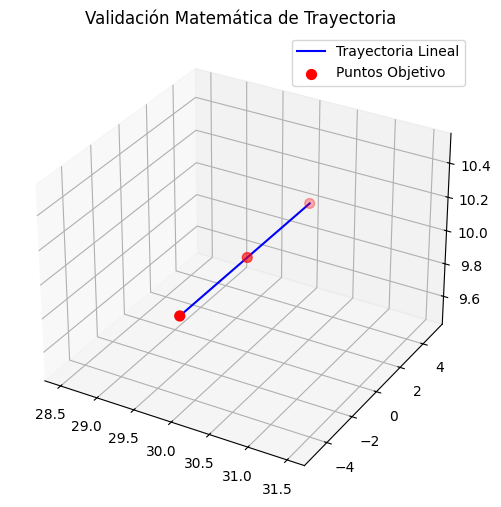

Validación Exitosa: El algoritmo genera una línea recta perfecta.


In [2]:
# Importamos la librería que acabamos de crear
from scara_kinematics import ScaraRobot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

robot = ScaraRobot()
P1 = (30.0, 5.0, 10.0); P2 = (30.0, 0.0, 10.0); P3 = (30.0, -5.0, 10.0)

# Generador de línea simple para la gráfica
def generar_linea(p_ini, p_fin, pasos=20):
    trayectoria = []
    for i in range(pasos + 1):
        t = i / pasos
        x = p_ini[0] + (p_fin[0] - p_ini[0]) * t
        y = p_ini[1] + (p_fin[1] - p_ini[1]) * t
        z = p_ini[2] + (p_fin[2] - p_ini[2]) * t
        trayectoria.append((x,y,z))
    return trayectoria

ruta = generar_linea(P1, P2) + generar_linea(P2, P3)

# Graficar
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
xs = [p[0] for p in ruta]; ys = [p[1] for p in ruta]; zs = [p[2] for p in ruta]
ax.plot(xs, ys, zs, c='blue', label='Trayectoria Lineal')
ax.scatter([30,30,30], [5,0,-5], [10,10,10], c='red', s=50, label='Puntos Objetivo')
ax.set_title("Validación Matemática de Trayectoria")
ax.legend()
plt.show()
print("Validación Exitosa: El algoritmo genera una línea recta perfecta.")

## 4. Implementación del Gemelo Digital
Para la visualización en tiempo real, se implementó una arquitectura Cliente-Servidor:
* **Backend:** Python Flask + SocketIO (Procesamiento cinemático).
* **Frontend:** Three.js (Renderizado 3D) + HTML5 (Interfaz de Control).
* **Hardware:** ESP32 (Control de Servos vía UDP).

A continuación se generan los archivos del sistema automáticamente.

In [3]:
import os
# Creamos la estructura de carpetas necesaria para Flask
if not os.path.exists('templates'):
    os.makedirs('templates')
if not os.path.exists('static'):
    os.makedirs('static')
print("✅ Carpetas 'templates' y 'static' creadas.")

✅ Carpetas 'templates' y 'static' creadas.


Generar Backend (App.py)

In [4]:
%%writefile app.py
import eventlet
eventlet.monkey_patch()

from flask import Flask, render_template, request
from flask_socketio import SocketIO, emit
import socket
import threading
import time
import sys
from scara_kinematics import ScaraRobot

app = Flask(__name__)
# Configuración para permitir conexiones desde cualquier origen (CORS) y modo asíncrono
socketio = SocketIO(app, cors_allowed_origins="*", async_mode='eventlet')

# ==========================================
# --- CONFIGURACIÓN DE RED ---
# ==========================================
# IP inicial del ESP32 (se actualizará automáticamente si el ESP32 manda PING)
ESP32_IP = "192.168.1.84"      
ESP32_PORT_SEND = 4210     # Puerto donde el ESP32 escucha comandos
SERVER_PORT_LISTEN = 5005  # Puerto donde este servidor escucha el PING del robot

sock_send = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock_listen = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

# ==========================================
# --- ESTADO GLOBAL ---
# ==========================================
robot = ScaraRobot() # Instancia de tu clase matemática
robot.grip = 0 

rutina_guardada = []
velocidad_actual = 50
emergency_active = False 

pendant_sid = None          # ID de sesión del celular (Teach Pendant)
robot_last_seen = 0         # Timestamp del último PING recibido
ROBOT_TIMEOUT = 4.0         # Segundos para considerar al robot desconectado

last_manual_command_time = 0 

# ==========================================
# 1. FUNCIONES AUXILIARES
# ==========================================
def get_local_ip():
    """Obtiene la IP real de la PC en la red WiFi para mostrar en el Pendant"""
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80)) # No envía nada, solo determina la interfaz de salida
        ip = s.getsockname()[0]
        s.close()
        return ip
    except Exception:
        return "127.0.0.1"

def enviar_a_esp32(q1, q2, z, grip):
    """Empaqueta y envía comandos UDP al microcontrolador"""
    # Actualizamos el estado interno del objeto robot
    robot.q1 = q1
    robot.q2 = q2
    robot.z = z
    robot.grip = int(grip)
    
    # Formato CSV simple: "q1,q2,z,grip"
    mensaje = f"{q1:.2f},{q2:.2f},{z:.2f},{int(grip)}"
    try:
        sock_send.sendto(mensaje.encode(), (ESP32_IP, ESP32_PORT_SEND))
    except Exception:
        pass 

def enviar_keepalive():
    """Mantiene la conexión viva con el ESP32"""
    try:
        sock_send.sendto(b"KEEPALIVE", (ESP32_IP, ESP32_PORT_SEND))
    except Exception:
        pass

def get_system_status():
    """Resumen del estado del sistema para el frontend"""
    is_robot_alive = (time.time() - robot_last_seen) < ROBOT_TIMEOUT
    return {
        'speed': velocidad_actual,
        'estop': emergency_active,
        'rutina': bool(rutina_guardada) and not emergency_active,
        'pendant': pendant_sid is not None,                       
        'robot_connected': is_robot_alive                         
    }

def emit_gemelo_update(broadcast=False):
    """
    Envía el estado completo al navegador (Panel y Pendant).
    Calcula FK y Matriz Homogénea antes de enviar.
    """
    # Calculamos la posición cartesiana actual basada en los ángulos actuales
    coords_data = robot.forward_kinematics(robot.q1, robot.q2, robot.z)
    
    payload = {
        'angulos': {'q1': robot.q1, 'q2': robot.q2, 'z': robot.z, 'grip': robot.grip},
        'coords': coords_data,
        'status': get_system_status()
    }
    socketio.emit('actualizar_gemelo', payload)

# ==========================================
# 2. HILOS DE FONDO (Background Threads)
# ==========================================
def udp_receiver_loop():
    """Escucha PINGS del ESP32 para autodescubrimiento de IP"""
    global robot_last_seen, ESP32_IP
    port_ok = False
    try:
        sock_listen.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        sock_listen.bind(('0.0.0.0', SERVER_PORT_LISTEN))
        sock_listen.settimeout(0.5)
        print(f"👂 Escuchando PINGS en puerto {SERVER_PORT_LISTEN}...")
        port_ok = True
    except Exception as e:
        print(f"❌ ERROR CRÍTICO: Puerto {SERVER_PORT_LISTEN} ocupado. {e}")
        return 

    if not port_ok: return

    while True:
        try:
            data, addr = sock_listen.recvfrom(1024)
            message = data.decode('utf-8', errors='ignore')
            if "PING" in message:
                robot_last_seen = time.time()
                # Si la IP cambió, la actualizamos dinámicamente
                if addr[0] != ESP32_IP:
                    ESP32_IP = addr[0]
                    print(f"🔄 Robot IP actualizada: {ESP32_IP}")
        except socket.timeout:
            pass
        except Exception:
            pass
        eventlet.sleep(0.1) 

def keep_alive_loop():
    """Hilo principal de 'latido' del servidor"""
    print("💓 Sistema Vital Iniciado...")
    while True:
        # Solo enviamos KeepAlive si no estamos moviendo manualmente (para no saturar red)
        if (time.time() - last_manual_command_time) > 0.5:
            enviar_keepalive() 
        
        # Actualizamos la interfaz web periódicamente (1Hz)
        emit_gemelo_update(broadcast=True)
        eventlet.sleep(1.0)

# ==========================================
# 3. RUTAS WEB
# ==========================================
@app.route('/')
def index(): return render_template('panel.html') # Por defecto abre el panel

@app.route('/panel')
def panel(): return render_template('panel.html')

@app.route('/pendant')
def pendant(): return render_template('pendant.html')

# ==========================================
# 4. EVENTOS SOCKET.IO (Lógica de Control)
# ==========================================
@socketio.on('connect')
def handle_connect(): 
    print(f"➕ Cliente conectado: {request.sid}")

@socketio.on('register_pendant')
def handle_pendant_reg():
    global pendant_sid
    pendant_sid = request.sid
    print(f"📱 TEACH PENDANT REGISTRADO")
    ip_address = get_local_ip()
    emit('server_status', {'ip': ip_address})
    emit_gemelo_update()

@socketio.on('disconnect')
def handle_disconnect():
    global pendant_sid
    if request.sid == pendant_sid:
        print("📱 TEACH PENDANT: Desconectado")
        pendant_sid = None
    emit_gemelo_update()

@socketio.on('cambiar_velocidad')
def handle_speed_change(data):
    global velocidad_actual
    velocidad_actual = int(data['velocidad'])
    emit_gemelo_update()

@socketio.on('comando_manual')
def handle_manual(data):
    """Mueve el robot por articulaciones (Joint Jogging)"""
    global last_manual_command_time
    if emergency_active: return
    
    last_manual_command_time = time.time()

    # Recibimos datos crudos
    q1 = float(data['q1'])
    q2 = float(data['q2'])
    z = float(data['z'])
    grip = int(data['grip'])

    # Enviamos al hardware
    enviar_a_esp32(q1, q2, z, grip)
    
    # Calculamos la cinemática directa para actualizar el 3D
    robot.forward_kinematics(q1, q2, z)
    
    # Actualizamos a todos los clientes (Panel y Pendant)
    emit_gemelo_update()

# ---------------------------------------------------------
#  MODIFICADO: EVENTO IK CON MOVIMIENTO SUAVE (INTERPOLACIÓN)
# ---------------------------------------------------------
@socketio.on('comando_ik')
def handle_ik_move(data):
    """Recibe X, Y, Z y calcula los ángulos para mover suavemente"""
    global last_manual_command_time
    
    if emergency_active:
        socketio.emit('notificacion', {'msg': '❌ ERROR: E-STOP ACTIVO', 'type': 'error'})
        return

    try:
        x_target = float(data['x'])
        y_target = float(data['y'])
        z_target = float(data['z'])
        
        # 1. Calcular el destino final (Ángulos Objetivo)
        resultado = robot.inverse_kinematics(x_target, y_target, z_target)
        
        if resultado is None:
            print(f"⚠️ Punto inalcanzable: {x_target}, {y_target}, {z_target}")
            socketio.emit('notificacion', {'msg': '⚠️ PUNTO FUERA DE ALCANCE', 'type': 'warning'})
        else:
            # Desempaquetamos los ángulos destino
            q1_target, q2_target, z_target_piston = resultado
            
            # 2. Capturar la posición actual (Ángulos Inicio)
            q1_start = robot.q1
            q2_start = robot.q2
            z_start  = robot.z
            
            # 3. Configuración de interpolación
            PASOS = 100  # Cantidad de pasos para suavidad (más pasos = más fluido)
            
            # Bloqueamos el keepalive manual mientras nos movemos
            last_manual_command_time = time.time() + 9999
            
            socketio.emit('notificacion', {'msg': 'MOVIMIENTO JOINT (ARCO)...', 'type': 'success'})

            # 4. Bucle de Movimiento (Interpolación Lineal)
            for i in range(1, PASOS + 1):
                if emergency_active: break
                
                # t es el porcentaje de avance (0.0 a 1.0)
                t = i / PASOS
                
                # Calcular posiciones intermedias
                current_q1 = q1_start + (q1_target - q1_start) * t
                current_q2 = q2_start + (q2_target - q2_start) * t
                current_z  = z_start  + (z_target_piston - z_start) * t
                
                # Enviar al hardware y al gemelo
                enviar_a_esp32(current_q1, current_q2, current_z, robot.grip)
                robot.forward_kinematics(current_q1, current_q2, current_z)
                emit_gemelo_update()
                
                # CÁLCULO DE VELOCIDAD
                # Ajustamos el 'sleep' según la velocidad_actual (0-100%)
                factor = max(velocidad_actual, 5) / 100.0
                delay = 0.02 / factor 
                eventlet.sleep(delay)
            
            last_manual_command_time = time.time() # Liberar KeepAlive
            
            socketio.emit('notificacion', {'msg': f'LLEGADA: X{x_target} Y{y_target}', 'type': 'success'})

    except ValueError:
        socketio.emit('notificacion', {'msg': '❌ Error en datos', 'type': 'error'})

# ---------------------------------------------------------
#  NUEVO: EVENTO PARA MOVIMIENTO LINEAL (LÍNEA RECTA)
# ---------------------------------------------------------
@socketio.on('comando_lineal')
def handle_linear_move(data):
    """Recibe X, Y, Z y mueve el efector en LÍNEA RECTA"""
    global last_manual_command_time
    
    if emergency_active:
        socketio.emit('notificacion', {'msg': '❌ ERROR: E-STOP ACTIVO', 'type': 'error'})
        return

    try:
        # 1. Datos del destino
        x_target = float(data['x'])
        y_target = float(data['y'])
        z_target = float(data['z'])
        
        # 2. Obtener coordenadas cartesianas ACTUALES (Punto de inicio)
        # Usamos Forward Kinematics para saber dónde estamos exactamente en X,Y
        current_coords = robot.forward_kinematics(robot.q1, robot.q2, robot.z)
        x_start = current_coords['final']['x']
        y_start = current_coords['final']['y']
        z_start = robot.D1_OFFSET - robot.z # <--- ASÍ ES CORRECTO ✅ (12.3 - extension)
        
        # 3. Configuración de interpolación
        PASOS = 50 # Más pasos para garantizar la rectitud de la línea
        last_manual_command_time = time.time() + 9999
        
        socketio.emit('notificacion', {'msg': 'TRAZANDO LINEA RECTA...', 'type': 'success'})
        
        valid_path = True

        # 4. Bucle de Interpolación Cartesiana
        for i in range(1, PASOS + 1):
            if emergency_active: break
            
            t = i / PASOS
            
            # --- LA MAGIA LINEAL ---
            # Calculamos el punto X, Y, Z intermedio geométrico
            next_x = x_start + (x_target - x_start) * t
            next_y = y_start + (y_target - y_start) * t
            next_z = z_start + (z_target - z_start) * t
            
            # Calculamos IK para este punto intermedio exacto
            # Esto obliga a los motores Q1 y Q2 a coordinarse para mantener la recta
            ik_result = robot.inverse_kinematics(next_x, next_y, next_z)
            
            if ik_result is None:
                socketio.emit('notificacion', {'msg': '⚠️ TRAYECTORIA IMPOSIBLE (SINGULARIDAD)', 'type': 'error'})
                valid_path = False
                break
            
            # Extraemos los ángulos resultantes para este milímetro de avance
            q1_next, q2_next, z_next_piston = ik_result
            
            # Enviamos
            enviar_a_esp32(q1_next, q2_next, z_next_piston, robot.grip)
            robot.forward_kinematics(q1_next, q2_next, z_next_piston)
            emit_gemelo_update()
            
            # Velocidad
            factor = max(velocidad_actual, 5) / 100.0
            delay = 0.02 / factor 
            eventlet.sleep(delay)
        
        last_manual_command_time = time.time()
        
        if valid_path:
            socketio.emit('notificacion', {'msg': 'MOVIMIENTO LINEAL FINALIZADO', 'type': 'success'})

    except ValueError:
        socketio.emit('notificacion', {'msg': '❌ Error en datos', 'type': 'error'})
# ---------------------------------------------------------

@socketio.on('request_status')
def send_status():
    emit_gemelo_update()
    ip_address = get_local_ip()
    emit('server_status', {'ip': ip_address})

@socketio.on('guardar_punto')
def guardar_punto(data):
    if emergency_active: return
    rutina_guardada.append(data)
    socketio.emit('notificacion', {'msg': f'Punto {len(rutina_guardada)} guardado', 'type': 'success'})
    emit_gemelo_update() 

@socketio.on('borrar_rutina')
def borrar_rutina():
    global rutina_guardada
    rutina_guardada = []
    emit_gemelo_update()

@socketio.on('ejecutar_rutina')
def ejecutar_rutina():
    """Ejecuta la lista de puntos interpolando el movimiento"""
    global emergency_active, last_manual_command_time
    if emergency_active or not rutina_guardada: return
    
    print("▶ Ejecutando Rutina...")
    emit_gemelo_update() 
    
    PASOS = 30 
    DELAY_BASE = 0.005 
    
    # Bloqueamos el KeepAlive manual mientras corre la rutina
    last_manual_command_time = time.time() + 99999 

    q1_act, q2_act, z_act = robot.q1, robot.q2, robot.z
    
    for punto in rutina_guardada:
        if emergency_active: break
        
        q1_tgt, q2_tgt = float(punto['q1']), float(punto['q2'])
        z_tgt, grip = float(punto['z']), int(punto['grip'])
        
        # Interpolación Lineal
        for paso in range(1, PASOS + 1):
            if emergency_active: break
            
            t = paso / PASOS
            q1 = q1_act + (q1_tgt - q1_act) * t
            q2 = q2_act + (q2_tgt - q2_act) * t
            z  = z_act  + (z_tgt - z_act) * t
            
            enviar_a_esp32(q1, q2, z, grip)
            robot.forward_kinematics(q1, q2, z)
            
            if paso % 5 == 0: emit_gemelo_update()
            
            factor = max(velocidad_actual, 1) / 100.0
            eventlet.sleep(DELAY_BASE / factor)
        
        q1_act, q2_act, z_act = q1_tgt, q2_tgt, z_tgt
        eventlet.sleep(0.5 / factor) # Pausa en cada punto
    
    last_manual_command_time = 0 # Liberar KeepAlive
    print("⏹ Rutina Finalizada")
    emit_gemelo_update() 

@socketio.on('emergency_stop')
def handle_emergency():
    global emergency_active
    emergency_active = not emergency_active
    print(f"🚨 ESTOP CAMBIO: {emergency_active}")
    emit_gemelo_update()

if __name__ == '__main__':
    # Lanzar hilos
    eventlet.spawn(udp_receiver_loop)
    eventlet.spawn(keep_alive_loop)
    
    print("🚀 SCARA SERVER V10 (LINEAR & JOINT MOTION) INICIADO")
    print(f"👉 Panel en: http://{get_local_ip()}:5000/panel")
    
    # Arrancar Servidor
    socketio.run(app, host='0.0.0.0', port=5000, debug=True, use_reloader=False)

Overwriting app.py


Generar Frontend (Panel.html)

In [5]:
%%writefile templates/panel.html
<!DOCTYPE html>
<html lang="es">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>SCARA | GEMELO DIGITAL</title>
    <style>
        /* --- ESTILO GENERAL TIPO HUD --- */
        body { 
            margin: 0; 
            overflow: hidden; 
            background-color: #0b0f19; /* Fondo muy oscuro, casi negro azulado */
            font-family: 'Segoe UI', sans-serif; 
            color: #e2e8f0; 
        }

        /* Fuente técnica para datos */
        @import url('https://fonts.googleapis.com/css2?family=Share+Tech+Mono&display=swap');
        .tech-font { font-family: 'Share Tech Mono', monospace; }

        /* --- BARRA SUPERIOR (HEADER) --- */
        .top-hud {
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 70px;
            background: rgba(15, 23, 42, 0.9);
            border-bottom: 2px solid #334155;
            box-shadow: 0 5px 20px rgba(0,0,0,0.5);
            display: flex;
            justify-content: space-between;
            align-items: center;
            padding: 0 30px;
            box-sizing: border-box;
            z-index: 100;
            backdrop-filter: blur(5px);
        }

        .hud-title {
            font-family: 'Share Tech Mono', monospace;
            font-size: 28px;
            color: #34d399;
            text-shadow: 0 0 10px rgba(52, 211, 153, 0.4);
            letter-spacing: 2px;
            text-align: center;
            flex-grow: 1; /* Ocupa el espacio central */
            border-left: 1px solid #334155;
            border-right: 1px solid #334155;
            height: 100%;
            display: flex;
            align-items: center;
            justify-content: center;
        }

        /* --- GRUPO DE INDICADORES LED --- */
        .indicators-group {
            display: flex;
            gap: 25px; /* Más espacio entre LEDs */
            min-width: 320px; /* Ancho mínimo para que quepan 3 */
        }
        .indicators-group.left { justify-content: flex-start; }
        .indicators-group.right { justify-content: flex-end; }

        .led-box {
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
        }

        .led-label {
            font-size: 9px;
            color: #94a3b8;
            margin-top: 4px;
            text-transform: uppercase;
            letter-spacing: 1px;
            font-weight: bold;
        }

        /* ESTILOS DE LEDS REALISTAS */
        .led {
            width: 16px;
            height: 16px;
            border-radius: 50%;
            background-color: #333; /* Estado apagado */
            border: 1px solid #555;
            box-shadow: inset 1px 1px 3px rgba(0,0,0,0.5);
            transition: all 0.2s;
        }

        /* Colores Encendidos */
        .led.on-green {
            background-color: #00ff00;
            box-shadow: 0 0 10px #00ff00, inset -2px -2px 5px rgba(0,0,0,0.2);
            border-color: #00cc00;
        }
        .led.on-blue {
            background-color: #00ccff;
            box-shadow: 0 0 10px #00ccff, inset -2px -2px 5px rgba(0,0,0,0.2);
            border-color: #0099cc;
        }
        .led.on-yellow {
            background-color: #ffcc00;
            box-shadow: 0 0 10px #ffcc00, inset -2px -2px 5px rgba(0,0,0,0.2);
            border-color: #cc9900;
            animation: blink 1s infinite; /* Parpadeo para rutina */
        }
        .led.on-red {
            background-color: #ff0000;
            box-shadow: 0 0 15px #ff0000, inset -2px -2px 5px rgba(0,0,0,0.2);
            border-color: #cc0000;
            animation: blink-fast 0.5s infinite; /* Parpadeo rápido emergencia */
        }
        .led.on-purple {
            background-color: #9900ff;
            box-shadow: 0 0 15px #9900ff, inset -2px -2px 5px rgba(0,0,0,0.2);
            border-color: #9900ff;
        }

        @keyframes blink { 50% { opacity: 0.5; } }
        @keyframes blink-fast { 50% { opacity: 0.3; } }

        /* --- PANELES FLOTANTES LATERALES --- */
        .hud-panel {
            position: absolute; 
            background: rgba(11, 15, 25, 0.85);
            border: 1px solid #334155; 
            border-left: 4px solid #34d399; /* Acento verde */
            border-radius: 4px;
            padding: 15px; 
            box-shadow: 0 10px 15px -3px rgba(0,0,0,0.5);
            /* pointer-events: none;  <-- REMOVIDO PARA PERMITIR CLICKS EN IK */
            backdrop-filter: blur(4px);
            transition: border-color 0.3s;
        }

        #info-box { top: 90px; left: 20px; width: 280px; pointer-events: none; }
        #matrix-box { bottom: 20px; right: 20px; width: 320px; border-left: none; border-right: 4px solid #34d399; pointer-events: none; }
        
        h2 { 
            margin: 0 0 10px 0; 
            font-size: 16px; 
            color: #34d399; 
            border-bottom: 1px solid #334155; 
            padding-bottom: 5px; 
            text-transform: uppercase; 
            letter-spacing: 1px;
        }

        .data-row { 
            display: flex; 
            justify-content: space-between; 
            margin-bottom: 6px; 
            font-size: 15px; 
            align-items: center;
        }
        
        .label { color: #94a3b8; font-size: 13px; }
        .val { color: #facc15; font-weight: bold; font-size: 16px; text-shadow: 0 0 5px rgba(250, 204, 21, 0.3); }
        .val-large { font-size: 20px; color: #38bdf8; } /* Para velocidad */

        /* Matriz Style */
        .matrix-grid {
            display: grid; grid-template-columns: repeat(4, 1fr); gap: 5px;
            font-size: 12px; text-align: right;
        }
        .mat-cell { background: #1e293b; padding: 4px; border-radius: 2px; color: #94a3b8; border: 1px solid #334155; }
        .mat-cell.highlight { color: #34d399; font-weight: bold; border-color: #34d399; background: rgba(52, 211, 153, 0.1); } 

        /* ================================================== */
        /* === ESTILOS NUEVOS AGREGADOS PARA EL PANEL IK === */
        /* ================================================== */
        
        /* Panel IK (Arco Natural) */
        #ik-box { top: 420px; left: 20px; width: 280px; pointer-events: auto; }
        
        /* Panel LINEAL (Nuevo) - Posicionado debajo del IK */
        #linear-box { top: 660px; left: 20px; width: 280px; pointer-events: auto; border-left-color: #06b6d4; }
        #linear-box h2 { color: #06b6d4; } /* Titulo azul cian */

        .ik-inputs { display: flex; flex-direction: column; gap: 8px; margin-bottom: 12px; }
        .input-group { display: flex; justify-content: space-between; align-items: center; }
        .input-group label { color: #34d399; font-size: 14px; }
        .input-group input { 
            background: #1e293b; border: 1px solid #334155; color: #facc15; 
            width: 100px; padding: 4px; text-align: right; font-family: 'Share Tech Mono';
            outline: none;
        }
        .input-group input:focus { border-color: #facc15; }
        
        /* Boton IK Normal (Verde) */
        .btn-ik {
            width: 100%; padding: 8px; background: rgba(52, 211, 153, 0.1); 
            border: 1px solid #34d399; color: #34d399; font-family: 'Share Tech Mono'; font-size: 14px;
            cursor: pointer; transition: all 0.2s; text-transform: uppercase; font-weight: bold;
        }
        .btn-ik:hover { background: #34d399; color: #0f172a; box-shadow: 0 0 15px rgba(52, 211, 153, 0.4); }
        .btn-ik:active { transform: translateY(2px); }

        /* Boton Lineal (Azul) */
        .btn-linear {
            width: 100%; padding: 8px; background: rgba(6, 182, 212, 0.1); 
            border: 1px solid #06b6d4; color: #06b6d4; font-family: 'Share Tech Mono'; font-size: 14px;
            cursor: pointer; transition: all 0.2s; text-transform: uppercase; font-weight: bold;
        }
        .btn-linear:hover { background: #06b6d4; color: #0f172a; box-shadow: 0 0 15px rgba(6, 182, 212, 0.4); }
        .btn-linear:active { transform: translateY(2px); }
        /* ================================================== */

    </style>

    <script src="https://cdn.tailwindcss.com"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/socket.io/4.0.1/socket.io.js"></script>
    <script type="importmap">
        { "imports": { "three": "https://cdn.jsdelivr.net/npm/three@0.160.0/build/three.module.js", "three/addons/": "https://cdn.jsdelivr.net/npm/three@0.160.0/examples/jsm/" } }
    </script>
</head>
<body>

    <div class="top-hud">
        <div class="indicators-group left" style="width: auto;">
            
            <div class="led-box">
                <div id="led-server" class="led"></div>
                <span class="led-label">SERVER</span>
            </div>

            <div class="led-box">
                <div id="led-robot" class="led"></div>
                <span class="led-label">ROBOT</span>
            </div>

            <div class="led-box">
                <div id="led-pendant" class="led"></div>
                <span class="led-label">PENDANT</span>
            </div>

        </div>

        <div class="hud-title">SCARA ROBOT</div>

        <div class="indicators-group right">
            <div class="led-box">
                <div id="led-rutina" class="led"></div>
                <span class="led-label">RUNNING</span>
            </div>
            <div class="led-box">
                <div id="led-estop" class="led"></div>
                <span class="led-label" style="color:#ef4444; font-weight:bold;">E-STOP</span>
            </div>
        </div>
    </div>

    <div id="info-box" class="hud-panel tech-font">
        <h2>PARAMETERS</h2>
        
        <div class="data-row">
            <span class="label">SPEED:</span> 
            <span id="textSpeed" class="val val-large">0%</span>
        </div>
        
        <hr style="border-color: #334155; opacity: 0.5; margin: 10px 0;">

        <div class="data-row"><span class="label">J1:</span> <span id="textQ1" class="val">0.00°</span></div>
        <div class="data-row"><span class="label">J2:</span> <span id="textQ2" class="val">0.00°</span></div>
        <div class="data-row"><span class="label">J3:</span> <span id="textZ" class="val">0.00 cm</span></div>
        <div class="data-row"><span class="label">GRIPPER:</span> <span id="textGrip" class="val" style="color:white;">--</span></div>
        
        <hr style="border-color: #334155; opacity: 0.5; margin: 10px 0;">
        
        <div class="data-row"><span class="label">POS X:</span> <span id="textX" class="val">0.00</span></div>
        <div class="data-row"><span class="label">POS Y:</span> <span id="textY" class="val">0.00</span></div>
        <div class="data-row"><span class="label">POS Z:</span> <span id="textZ_world" class="val">0.00</span></div>
    </div>

    <div id="ik-box" class="hud-panel tech-font">
        <h2>MOVIMIENTO LIBRE (JOINT)</h2>
        
        <div class="ik-inputs">
            <div class="input-group">
                <label>TARGET X:</label>
                <input type="number" id="inpX" value="28.0" step="0.5">
            </div>
            <div class="input-group">
                <label>TARGET Y:</label>
                <input type="number" id="inpY" value="0.0" step="0.5">
            </div>
            <div class="input-group">
                <label>TARGET Z:</label>
                <input type="number" id="inpZ" value="0.0" step="0.5" max="4.3" min="0">
            </div>
        </div>

        <button onclick="enviarIK()" class="btn-ik">MOVER (ARCO)</button>
        <div id="ik-msg" style="margin-top:8px; font-size:11px; color:#64748b; text-align:center; height:15px;">SYSTEM READY</div>
    </div>

    <div id="linear-box" class="hud-panel tech-font">
        <h2>MOVIMIENTO LINEAL</h2>
        
        <div class="ik-inputs">
            <div class="input-group">
                <label style="color:#06b6d4">LIN TGT X:</label>
                <input type="number" id="linX" value="30.0" step="0.5" style="color:#06b6d4; border-color:#06b6d4;">
            </div>
            <div class="input-group">
                <label style="color:#06b6d4">LIN TGT Y:</label>
                <input type="number" id="linY" value="5.0" step="0.5" style="color:#06b6d4; border-color:#06b6d4;">
            </div>
            <div class="input-group">
                <label style="color:#06b6d4">LIN TGT Z:</label>
                <input type="number" id="linZ" value="0.0" step="0.5" max="4.3" min="0" style="color:#06b6d4; border-color:#06b6d4;">
            </div>
        </div>

        <button onclick="enviarLineal()" class="btn-linear">MOVER (RECTO)</button>
        <div id="lin-msg" style="margin-top:8px; font-size:11px; color:#64748b; text-align:center; height:15px;">WAITING CMD</div>
    </div>
    <div id="matrix-box" class="hud-panel tech-font">
        <h2>MATRIZ DE TRANSFORMACIÓN (T)</h2>
        <div class="matrix-grid" id="matrix-display">
            <div class="mat-cell">1</div><div class="mat-cell">0</div><div class="mat-cell">0</div><div class="mat-cell highlight">0</div>
            <div class="mat-cell">0</div><div class="mat-cell">1</div><div class="mat-cell">0</div><div class="mat-cell highlight">0</div>
            <div class="mat-cell">0</div><div class="mat-cell">0</div><div class="mat-cell">1</div><div class="mat-cell highlight">0</div>
            <div class="mat-cell">0</div><div class="mat-cell">0</div><div class="mat-cell">0</div><div class="mat-cell">1</div>
        </div>
        <div style="margin-top:10px; font-size:10px; color:#64748b; text-align:center;">
            CINEMÁTICA DIRECTA CALCULADA EN TIEMPO REAL
        </div>
    </div>

    <script type="module">
        import * as THREE from 'three';
        import { OrbitControls } from 'three/addons/controls/OrbitControls.js';
        import { STLLoader } from 'three/addons/loaders/STLLoader.js';

        // --- 1. ESCENA ---
        const scene = new THREE.Scene();
        scene.background = new THREE.Color(0x0b0f19); // Match body background
        scene.fog = new THREE.Fog(0x0b0f19, 80, 300);

        const camera = new THREE.PerspectiveCamera(45, window.innerWidth / window.innerHeight, 0.1, 1000);
        camera.position.set(60, 60, 80);
        camera.lookAt(0, 10, 0);

        const renderer = new THREE.WebGLRenderer({ antialias: true });
        renderer.setSize(window.innerWidth, window.innerHeight);
        renderer.shadowMap.enabled = true;
        document.body.appendChild(renderer.domElement);

        const controls = new OrbitControls(camera, renderer.domElement);
        controls.enableDamping = true;
        controls.target.set(0, 10, 0);

        // Luces
        const ambientLight = new THREE.AmbientLight(0xffffff, 0.6);
        scene.add(ambientLight);
        const dirLight = new THREE.DirectionalLight(0xffffff, 1.5);
        dirLight.position.set(50, 100, 50);
        dirLight.castShadow = true;
        scene.add(dirLight);

        // Suelo y Grid (Estilo Cyberpunk)
        const gridHelper = new THREE.GridHelper(100, 20, 0x34d399, 0x1e293b);
        scene.add(gridHelper);
        const axesHelper = new THREE.AxesHelper(10);
        scene.add(axesHelper);

        // --- TRAZADO DE TRAYECTORIA ---
        const MAX_TRAIL = 1000;
        const trailGeo = new THREE.BufferGeometry();
        const trailPos = new Float32Array(MAX_TRAIL * 3);
        trailGeo.setAttribute('position', new THREE.BufferAttribute(trailPos, 3));
        const trailMat = new THREE.LineBasicMaterial({ color: 0xf43f5e, linewidth: 3 });
        const trailLine = new THREE.Line(trailGeo, trailMat);
        scene.add(trailLine);

        // --- 2. CINEMÁTICA Y PROPIEDADES ---
        const KIN_L1 = 28.9818176;
        const KIN_L2 = 12.4700356; 
        const KIN_BASE_H = 12.3;
        const KIN_Z_TRAVEL = 4.3;
        const VIS_BASE_D = 14.0;
        const VIS_BASE_H = 11.0;
        const VIS_ARM1_H = 2.5;
        const VIS_ARM2_H = 15.0; 
        const VIS_BASE_BOX_W = 9.5;
        const VIS_BASE_BOX_D = 4.0;
        
        const matYellow = new THREE.MeshStandardMaterial({ color: 0xffe01a, roughness: 0.6, metalness: 0.1 });
        const matBlack = new THREE.MeshStandardMaterial({ color: 0x111111, roughness: 0.8, metalness: 0.1 });
        const matSilver = new THREE.MeshStandardMaterial({ color: 0xcccccc, roughness: 0.2, metalness: 0.8 });
        const matTube = new THREE.MeshStandardMaterial({ color: 0x050505, roughness: 0.8 });

        // --- 3. GRUPOS Y GEOMETRÍAS BASE ---
        const baseGroup = new THREE.Group();
        baseGroup.position.set(-11.2767, 0.0000, -7.2834); 
        scene.add(baseGroup);

        const baseCylGeo = new THREE.CylinderGeometry(VIS_BASE_D/2, VIS_BASE_D/2, VIS_BASE_H, 32);
        const baseCylMesh = new THREE.Mesh(baseCylGeo, matBlack);
        baseCylMesh.position.y = VIS_BASE_H / 2;
        baseGroup.add(baseCylMesh);
        baseCylMesh.visible = false; 

        const baseBoxGeo = new THREE.BoxGeometry(VIS_BASE_BOX_D, VIS_BASE_H, VIS_BASE_BOX_W);
        const baseBoxMesh = new THREE.Mesh(baseBoxGeo, matBlack);
        baseBoxMesh.position.y = VIS_BASE_H / 2;
        baseBoxMesh.position.x = -(VIS_BASE_D/2) - (VIS_BASE_BOX_D/2);
        baseGroup.add(baseBoxMesh);
        baseBoxMesh.visible = false; 

        const pivotQ1 = new THREE.Group();
        pivotQ1.position.y = KIN_BASE_H; 
        scene.add(pivotQ1);

        const pivotQ2 = new THREE.Group();
        pivotQ2.position.x = KIN_L1; 
        pivotQ1.add(pivotQ2);

        const zPistonGroup = new THREE.Group();
        const z_retracted_y = (VIS_ARM2_H / 2) - (VIS_ARM1_H / 2);
        zPistonGroup.position.x = KIN_L2; 
        zPistonGroup.position.y = z_retracted_y;
        pivotQ2.add(zPistonGroup);

        const zRodVisualLength = KIN_Z_TRAVEL + (VIS_ARM2_H / 2);
        const zRodGeo = new THREE.CylinderGeometry(1, 1, zRodVisualLength, 32);
        const zRodMesh = new THREE.Mesh(zRodGeo, matBlack);
        zRodMesh.position.y = -(zRodVisualLength / 2);
        zPistonGroup.add(zRodMesh);
        zRodMesh.visible = false; 

        const gripperGroup = new THREE.Group();
        gripperGroup.position.y = -zRodVisualLength;
        zPistonGroup.add(gripperGroup);

        // FUELLE (Cable)
        const p1_base_anchor = new THREE.Object3D();
        p1_base_anchor.position.set(2.4913, 8.2651, 7.0541); 
        p1_base_anchor.rotation.set(-3.0834, 0.0000, 0.0000); 
        baseGroup.add(p1_base_anchor);

        const p3_head_anchor = new THREE.Object3D();
        p3_head_anchor.position.set(0.0900, 14.0000, 0.1000); 
        p3_head_anchor.rotation.set(-3.1294, 0.0000, 0.0000); 
        pivotQ2.add(p3_head_anchor);

        const tubePathInitial = new THREE.CatmullRomCurve3([
            new THREE.Vector3(0, 0, 0), new THREE.Vector3(0, 10, 0), 
            new THREE.Vector3(10, 10, 0), new THREE.Vector3(10, 0, 0)
        ]);
        let tubeMesh = new THREE.Mesh(new THREE.TubeGeometry(tubePathInitial, 20, 1.2, 8, false), matTube);
        scene.add(tubeMesh);


        // --- 4. STL LOADER ---
        const loader = new STLLoader();
        function makeMeshFromSTL(geometry, material) {
            geometry.computeVertexNormals();
            const mesh = new THREE.Mesh(geometry, material);
            mesh.castShadow = true;
            mesh.receiveShadow = true;
            return mesh;
        }
        const basePath = '/static/models/'; 

        loader.load(encodeURI(basePath + 'SCARA Base.STL'), geometry => {
            const mesh = makeMeshFromSTL(geometry, matBlack);
            mesh.scale.set(0.1, 0.1, 0.1); 
            baseGroup.add(mesh);
        });

        loader.load(encodeURI(basePath + 'SCARA Eslabon 1.STL'), geometry => {
            const mesh = makeMeshFromSTL(geometry, matYellow);
            mesh.position.set(-7.2181, -4.1452, -6.5986); 
            mesh.rotation.set(0, 0.049, 0); 
            mesh.scale.set(0.1, 0.1, 0.1); 
            pivotQ1.add(mesh);
        });

        loader.load(encodeURI(basePath + 'SCARA Eslabon 2.STL'), geometry => {
            const mesh = makeMeshFromSTL(geometry, matYellow);
            mesh.position.set(-29.3145, -4.2058, -4.5607);
            mesh.rotation.set(0, 0.0256, 0); 
            mesh.scale.set(0.1, 0.1, 0.1); 
            pivotQ2.add(mesh);
        });

        let gripperOpenMesh = null, gripperClosedMesh = null;
        loader.load(encodeURI(basePath + 'SCARA Gripper abierto.STL'), geometry => {
            gripperOpenMesh = makeMeshFromSTL(geometry, matSilver);
            gripperOpenMesh.position.set(-41.71490309, -0.57231529, -4.53757927); 
            gripperOpenMesh.scale.set(0.1, 0.1, 0.1); 
            gripperGroup.add(gripperOpenMesh);
        });
        loader.load(encodeURI(basePath + 'SCARA Gripper cerrado.STL'), geometry => {
            gripperClosedMesh = makeMeshFromSTL(geometry, matSilver);
            gripperClosedMesh.visible = false;
            gripperClosedMesh.position.set(-41.71490309, -1.57231529, -4.53757927); 
            gripperClosedMesh.scale.set(0.1, 0.1, 0.1); 
            gripperGroup.add(gripperClosedMesh);
        });

        // --- 5. SOCKET.IO & ACTUALIZACIÓN ---
        window.socket = io(); // MODIFICADO: Asignar a window para usar en enviarIK
        
        // Elementos LED (AHORA SON 3)
        const ledServer = document.getElementById('led-server');
        const ledRobot = document.getElementById('led-robot');
        const ledPendant = document.getElementById('led-pendant');
        const ledRutina = document.getElementById('led-rutina');
        const ledEstop = document.getElementById('led-estop');

        // 1. LED SERVIDOR: Se enciende cuando el socket conecta
        window.socket.on('connect', () => { 
            ledServer.classList.add('on-green'); 
            console.log("Conectado al servidor SCARA");
        });
        
        window.socket.on('disconnect', () => { 
            // Si perdemos el server, apagamos TODOS los LEDs de conexión
            ledServer.classList.remove('on-green');
            ledRobot.classList.remove('on-green');
            ledPendant.classList.remove('on-blue');
            
            // Y los de estado
            ledRutina.classList.remove('on-yellow');
            ledEstop.classList.remove('on-red');
        });

        // =============================================
        // === NUEVO LISTENER PARA NOTIFICACIONES IK ===
        // =============================================
        window.socket.on('notificacion', (data) => {
            // 1. Manejar panel IK normal
            const msgBox = document.getElementById('ik-msg');
            const box = document.getElementById('ik-box');
            
            // 2. Manejar panel LINEAL (Nuevo)
            const linMsgBox = document.getElementById('lin-msg');
            const linBox = document.getElementById('linear-box');

            // Actualizamos texto en ambos para feedback global
            msgBox.innerText = data.msg;
            linMsgBox.innerText = data.msg;
            
            let color = "#34d399";
            let borderCol = "#34d399";

            if(data.type === 'error') {
                color = "#ef4444"; 
                borderCol = "#ef4444";
            } else if (data.type === 'warning') {
                color = "#f59e0b"; 
                borderCol = "#f59e0b";
            } else {
                // Éxito
                color = "#34d399"; 
                borderCol = "#34d399";
            }

            msgBox.style.color = color;
            box.style.borderColor = borderCol;
            
            // Para el lineal usamos azul cian si es éxito
            if(data.type !== 'error' && data.type !== 'warning'){
                 linMsgBox.style.color = "#06b6d4";
                 linBox.style.borderColor = "#06b6d4";
            } else {
                 linMsgBox.style.color = color;
                 linBox.style.borderColor = borderCol;
            }

            // Restaurar borde después de 1.5s
            setTimeout(() => { 
                box.style.borderColor = "#334155"; 
                linBox.style.borderColor = "#334155";
            }, 1500);
        });
        // =============================================

        window.socket.on('actualizar_gemelo', (data) => {
            if (!data || !data.angulos) return;

            // Actualizar Telemetría Básica
            document.getElementById('textQ1').innerText = parseFloat(data.angulos.q1).toFixed(2) + "°";
            document.getElementById('textQ2').innerText = parseFloat(data.angulos.q2).toFixed(2) + "°";
            document.getElementById('textZ').innerText  = parseFloat(data.angulos.z).toFixed(2) + " cm";
            
            const gripClosed = data.angulos.grip === 1;
            const txtGrip = document.getElementById('textGrip');
            txtGrip.innerText = gripClosed ? "CLOSED" : "OPEN";
            txtGrip.style.color = gripClosed ? "#facc15" : "#34d399";

            // Coordenadas y Matriz
            if (data.coords && data.coords.final) {
                document.getElementById('textX').innerText = data.coords.final.x.toFixed(2);
                document.getElementById('textY').innerText = data.coords.final.y.toFixed(2);
                document.getElementById('textZ_world').innerText = data.coords.final.z.toFixed(2);
                
                if (data.coords.matrix) {
                    updateMatrixDisplay(data.coords.matrix);
                }
            }

            // --- LÓGICA DE ESTADO ---
            if (data.status) {
                // A) VELOCIDAD
                if (data.status.speed !== undefined) {
                    document.getElementById('textSpeed').innerText = data.status.speed + "%";
                }

                // B) ESTADO DE LOS LEDS
                
                // 2. LED ROBOT FÍSICO (Heartbeat)
                if (data.status.robot_connected) {
                    ledRobot.classList.add('on-purple'); 
                } else {
                    ledRobot.classList.remove('on-purple'); 
                }

                // 3. LED TEACH PENDANT
                if (data.status.pendant) {
                    ledPendant.classList.add('on-blue');
                } else {
                    ledPendant.classList.remove('on-blue');
                }

                // E-STOP & RUTINA
                if (data.status.estop) ledEstop.classList.add('on-red');
                else ledEstop.classList.remove('on-red');

                if (data.status.rutina) ledRutina.classList.add('on-yellow');
                else ledRutina.classList.remove('on-yellow');
            }

            // Mover Robot 3D
            const degToRad = Math.PI / 180;
            pivotQ1.rotation.y = data.angulos.q1 * degToRad;
            pivotQ2.rotation.y = data.angulos.q2 * degToRad;
            zPistonGroup.position.y = z_retracted_y - data.angulos.z;

            // Gripper Visual
            if (gripperOpenMesh && gripperClosedMesh) {
                gripperOpenMesh.visible = !gripClosed;
                gripperClosedMesh.visible = gripClosed;
            }

            // Trail
            const tcpWorldPos = new THREE.Vector3();
            gripperGroup.getWorldPosition(tcpWorldPos);
            tcpWorldPos.y -= 0.99; 
            updateTrail(tcpWorldPos);
        });

        function updateMatrixDisplay(mat) {
            const grid = document.getElementById('matrix-display');
            grid.innerHTML = '';
            mat.forEach((val, i) => {
                const div = document.createElement('div');
                div.className = 'mat-cell';
                if (i === 3 || i === 7 || i === 11) div.classList.add('highlight');
                div.innerText = val.toFixed(2);
                grid.appendChild(div);
            });
        }

        function updateTrail(pos) {
            const positions = trailLine.geometry.attributes.position.array;
            for (let i = 0; i < (MAX_TRAIL - 1) * 3; i++) {
                positions[i] = positions[i + 3];
            }
            const idx = (MAX_TRAIL - 1) * 3;
            positions[idx] = pos.x;
            positions[idx+1] = pos.y;
            positions[idx+2] = pos.z;
            trailLine.geometry.attributes.position.needsUpdate = true;
        }

// --- ANIMACIÓN DEL CABLE (CURVA NATURAL BEZIER) ---
        function getAnchorWorldPosition(anchorObject, offsetMultiplier) {
            const worldPos = new THREE.Vector3();
            anchorObject.getWorldPosition(worldPos);
            const worldDir = new THREE.Vector3(0, -1, 0); 
            worldDir.applyQuaternion(anchorObject.getWorldQuaternion(new THREE.Quaternion()));
            return worldPos.add(worldDir.multiplyScalar(offsetMultiplier));
        }

        function animate() {
            requestAnimationFrame(animate);
            controls.update();

            // 1. Obtener posiciones de los anclajes (donde empieza y termina el cable)
            // Ajusta el '3' si quieres que el cable salga más "adentro" o "afuera" del conector
            const P1_world = getAnchorWorldPosition(p1_base_anchor, 3); 
            const P2_world = getAnchorWorldPosition(p3_head_anchor, 3); 
            
            // 2. Calcular la distancia para saber cuánto debe "colgar"
            const distance = P1_world.distanceTo(P2_world);
            
            // FACTOR DE GRAVEDAD:
            // 0.5 = Curva moderada
            // 0.8 = Cable muy pesado/largo (cuelga mucho)
            // 0.3 = Cable tenso/corto
            const sagFactor = 0.99; 

            // 3. Calcular Puntos de Control (Gravedad simulada)
            const controlPoint1 = P1_world.clone();
            controlPoint1.y += distance * sagFactor * 0.6; // Subimos un poco para hacer el arco inicial
            
            const controlPoint2 = P2_world.clone();
            controlPoint2.y += distance * sagFactor * 0.2; // Subimos para el arco final

            // NOTA: Si quisieras que colgara hacia abajo estrictamente como una cadena floja,
            // usarías -= en lugar de +=. Pero para un tubo corrugado que sale hacia ARRIBA
            // (como en tu foto), los puntos de control deben estar ARRIBA para formar el arco.
            
            // Ajuste fino para que se parezca a tu foto (arco alto)
            // Forzamos que los puntos de control estén siempre por encima de la altura máxima del robot
            controlPoint1.y = Math.max(controlPoint1.y, 25); 
            controlPoint2.y = Math.max(controlPoint2.y, 25);

            const newPath = new THREE.CubicBezierCurve3(
                P1_world,      // Inicio (Base)
                controlPoint1, // Control 1 (Cima del arco lado base)
                controlPoint2, // Control 2 (Cima del arco lado cabezal)
                P2_world       // Fin (Cabezal)
            );

            tubeMesh.geometry.dispose();
            tubeMesh.geometry = new THREE.TubeGeometry(newPath, 60, 0.9, 8, false); 

            renderer.render(scene, camera);
        }
        
        window.onload = animate;
        window.addEventListener('resize', () => {
            camera.aspect = window.innerWidth / window.innerHeight;
            camera.updateProjectionMatrix();
            renderer.setSize(window.innerWidth, window.innerHeight);
        });

        // =============================================
        // === FUNCIONES GLOBALES PARA EL HTML (IK) ===
        // =============================================
        window.enviarIK = function() {
            const x = document.getElementById('inpX').value;
            const y = document.getElementById('inpY').value;
            const z = document.getElementById('inpZ').value;
            
            // Feedback inmediato
            document.getElementById('ik-msg').innerText = "CALCULANDO...";
            document.getElementById('ik-msg').style.color = "#fbbf24";
            
            window.socket.emit('comando_ik', { x: x, y: y, z: z });
        };

        // NUEVA FUNCIÓN PARA EL PANEL LINEAL
        window.enviarLineal = function() {
            const x = document.getElementById('linX').value;
            const y = document.getElementById('linY').value;
            const z = document.getElementById('linZ').value;
            
            // Feedback inmediato en panel lineal
            document.getElementById('lin-msg').innerText = "TRAZANDO...";
            document.getElementById('lin-msg').style.color = "#06b6d4";
            
            window.socket.emit('comando_lineal', { x: x, y: y, z: z });
        };
        // =============================================

    </script>
    <div style="
        position: absolute; 
        bottom: 2px; 
        width: 100%; 
        text-align: center; 
        font-family: 'Share Tech Mono', monospace; 
        font-size: 10px; 
        color: #4b5563; 
        pointer-events: none;
        opacity: 1.0;
    ">
        Este SCARA es producto de desvelos, un pacto con el diablo y la esquizofrenia del Gabo. No lo toques, no lo muevas y no lo veas, si falla es culpa del Juancho.
    </div>
</body>
</html>

Overwriting templates/panel.html


Generar Teach Pendant (Pendant.html)

In [6]:
%%writefile templates/pendant.html
<!DOCTYPE html>
<html lang="es">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=0.9, user-scalable=yes">
    <title>Teach Pendant V2</title>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/socket.io/4.0.1/socket.io.js"></script>
    <link href="https://fonts.googleapis.com/css2?family=Share+Tech+Mono&display=swap" rel="stylesheet">
    
    <style>
        /* --- ESTILOS (Mismos que tu versión anterior) --- */
        body {
            background-color: #121212;
            display: flex;
            justify-content: center;
            align-items: flex-start;
            min-height: 100vh;
            margin: 0;
            font-family: sans-serif;
            overflow-y: auto; 
            -webkit-user-select: none;
            user-select: none;
            -webkit-touch-callout: none;
            padding-top: 20px; 
            padding-bottom: 50px;
        }

        .pendant-case {
            width: 90%; 
            max-width: 380px; 
            height: auto; 
            min-height: 700px; 
            background-color: #3a3a3c;
            border-radius: 30px;
            box-shadow: inset 5px 5px 15px rgba(255,255,255,0.1), inset -5px -5px 15px rgba(0,0,0,0.5), 10px 10px 30px rgba(0,0,0,0.8);
            padding: 15px;
            display: flex;
            flex-direction: column;
            position: relative;
            border: 4px solid #2c2c2e;
        }

        .top-bar {
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 10px;
        }

        .e-stop {
            width: 55px;
            height: 55px;
            background: radial-gradient(circle at 30% 30%, #ff4d4d, #cc0000);
            border-radius: 50%;
            border: 3px solid #800000;
            box-shadow: 0 5px 10px rgba(0,0,0,0.6);
            cursor: pointer;
            display: flex;
            align-items: center;
            justify-content: center;
            font-weight: bold;
            color: white;
            font-size: 9px;
            text-align: center;
        }
        .e-stop:active { transform: scale(0.95); box-shadow: 0 2px 5px rgba(0,0,0,0.6); }

        .power-switch {
            background: #222;
            color: #00ff00;
            padding: 8px 12px;
            border-radius: 5px;
            font-size: 11px;
            border: 1px solid #555;
            cursor: pointer;
        }
        .power-switch.off { color: #555; }

        .lcd-screen {
            background-color: #9ea792;
            color: #1a1a1a;
            font-family: 'Share Tech Mono', monospace;
            border: 6px solid #111;
            border-radius: 4px;
            padding: 8px;
            height: auto; 
            min-height: 200px;
            box-shadow: inset 2px 2px 10px rgba(0,0,0,0.4);
            margin-bottom: 15px;
            display: flex;
            flex-direction: column;
            justify-content: space-between;
        }

        .status-bar {
            font-size: 11px;
            border-bottom: 2px solid #1a1a1a;
            padding-bottom: 3px;
            display: flex;
            justify-content: space-between;
            font-weight: bold;
        }

        .data-lines { font-size: 15px; line-height: 1.3; margin-top: 5px; }
        .coord-label { font-weight: bold; margin-right: 8px; }
        
        .system-msg {
            background: #1a1a1a;
            color: #9ea792;
            padding: 3px;
            font-size: 10px;
            text-align: center;
            margin-top: 5px;
        }

        .keypad {
            display: grid;
            grid-template-columns: repeat(3, 1fr);
            gap: 8px;
            flex-grow: 1;
            background: #2c2c2e;
            padding: 10px;
            border-radius: 10px;
            border: 1px solid #555;
        }

        .key {
            background: linear-gradient(to bottom, #3b82f6, #1d4ed8);
            color: white;
            border: none;
            border-radius: 6px;
            font-weight: bold;
            font-size: 13px;
            cursor: pointer;
            box-shadow: 0 4px 0 #1e3a8a;
            height: 50px;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            touch-action: manipulation; 
            -webkit-tap-highlight-color: transparent;
        }
        
        .key:active { transform: translateY(4px); box-shadow: 0 0 0 #1e3a8a; }
        .key span { font-size: 8px; opacity: 0.8; margin-top: 1px; }

        .key.grey { background: linear-gradient(to bottom, #6b7280, #4b5563); box-shadow: 0 4px 0 #374151; }
        .key.dark-grey { background: linear-gradient(to bottom, #4b5563, #374151); box-shadow: 0 4px 0 #1f2937; font-size: 10px; }
        .key.yellow { background: linear-gradient(to bottom, #eab308, #ca8a04); box-shadow: 0 4px 0 #854d0e; color: black; }
        .key.green { background: linear-gradient(to bottom, #22c55e, #15803d); box-shadow: 0 4px 0 #14532d; }
        .key.red { background: linear-gradient(to bottom, #ef4444, #b91c1c); box-shadow: 0 4px 0 #7f1d1d; }

        .span-2 { grid-column: span 2; }
        
        .speed-display {
            background: #111;
            color: #00ffcc;
            font-family: 'Share Tech Mono', monospace;
            display: flex;
            align-items: center;
            justify-content: center;
            border-radius: 4px;
            border: 1px solid #555;
            font-size: 16px;
            box-shadow: inset 0 0 5px rgba(0,255,204,0.2);
        }

    </style>
</head>
<body>

    <div class="pendant-case">
        <div class="top-bar">
            <div class="e-stop" onclick="emergencia()">E-STOP</div>
            <div id="pwrBtn" class="power-switch" onclick="togglePower()">⚡ MOTOR OFF</div>
        </div>

        <div class="lcd-screen">
            <div class="status-bar">
                <span id="wifiStatus">WiFi: OK</span>
                <span id="speedOvr">SPEED: 50%</span>
            </div>
            <div style="font-size: 10px; text-align: right; border-bottom: 1px solid #1a1a1a; margin-bottom: 5px;">
                <span id="ipDisplay">IP: ...</span>
            </div>
            
            <div class="data-lines">
                <div><span class="coord-label">J1:</span> <span id="lcd-q1">0.0</span>°</div>
                <div><span class="coord-label">J2:</span> <span id="lcd-q2">0.0</span>°</div>
                <div><span class="coord-label">J3 :</span> <span id="lcd-z">0.0</span> cm</div>
                <hr style="border-color: #1a1a1a; opacity: 0.3; margin: 3px 0;">
                <div><span class="coord-label">X:</span> <span id="lcd-x">0.00</span></div>
                <div><span class="coord-label">Y:</span> <span id="lcd-y">0.00</span></div>
            </div>

            <div class="system-msg" id="sysMsg">SISTEM READY</div>
        </div>

        <div class="keypad">
            <!-- CONTROL VELOCIDAD -->
            <button class="key dark-grey" onclick="changeSpeed(-5)">SPEED<br>▼</button>
            <div class="speed-display" id="keypadSpeed">50%</div>
            <button class="key dark-grey" onclick="changeSpeed(5)">SPEED<br>▲</button>

            <!-- EJE J1 -->
            <button class="key" 
                onmousedown="startJog('q1', 1, event)" onmouseup="stopJog(event)" onmouseleave="stopJog(event)"
                ontouchstart="startJog('q1', 1, event)" ontouchend="stopJog(event)">
                J1+<br><span>(Left)</span>
            </button>
            
            <button class="key grey" onclick="goHome()">HOME</button>
            
            <button class="key" 
                onmousedown="startJog('q1', -1, event)" onmouseup="stopJog(event)" onmouseleave="stopJog(event)"
                ontouchstart="startJog('q1', -1, event)" ontouchend="stopJog(event)">
                J1-<br><span>(Rigth)</span>
            </button>

            <!-- EJE J2 -->
            <button class="key" 
                onmousedown="startJog('q2', 1, event)" onmouseup="stopJog(event)" onmouseleave="stopJog(event)"
                ontouchstart="startJog('q2', 1, event)" ontouchend="stopJog(event)">
                J2+<br><span>(Left)</span>
            </button>
            
            <button class="key grey" onclick="resetToZero()">RESET</button>
            
            <button class="key" 
                onmousedown="startJog('q2', -1, event)" onmouseup="stopJog(event)" onmouseleave="stopJog(event)"
                ontouchstart="startJog('q2', -1, event)" ontouchend="stopJog(event)">
                J2-<br><span>(Rigth)</span>
            </button>

            <!-- EJE Z -->
            <button class="key" 
                onmousedown="startJog('z', -1, event)" onmouseup="stopJog(event)" onmouseleave="stopJog(event)"
                ontouchstart="startJog('z', -1, event)" ontouchend="stopJog(event)">
                J3+<br><span>(Up)</span>
            </button>
            
            <button class="key red" onclick="toggleGrip()">GRIPPER</button>
            
            <button class="key" 
                onmousedown="startJog('z', 1, event)" onmouseup="stopJog(event)" onmouseleave="stopJog(event)"
                ontouchstart="startJog('z', 1, event)" ontouchend="stopJog(event)">
                J3-<br><span>(Down)</span>
            </button>

            <!-- Acciones -->
            <button class="key yellow span-2" onclick="guardarPunto()">SAVE COORDINATE</button>
            <button class="key green" onclick="ejecutarRutina()">RUN</button>
        </div>
    </div>

<script>
    const socket = io();

    let currentQ1 = 0;
    let currentQ2 = 0;
    let currentZ = 0;
    let gripState = 0;
    let motorOn = false;
    let jogInterval = null;
    let teachEnabled = true;

    let jogSpeedPercent = 50; 
    const MAX_STEP_DEG = 5.0; 
    const MAX_STEP_Z = 0.5;

    // Bandera para evitar carrera de datos (Data Race)
    let isJogging = false;

    document.addEventListener('contextmenu', event => event.preventDefault());

    socket.on('connect', () => {
        document.getElementById('sysMsg').innerText = "ONLINE";
        document.getElementById('wifiStatus').innerText = "WiFi: OK";
        
        // --- CAMBIO CLAVE: IDENTIFICACIÓN ---
        socket.emit('register_pendant'); 
        console.log("Enviada señal de registro PENDANT");
        
        socket.emit('request_status');
    });

    socket.on('disconnect', () => {
        document.getElementById('sysMsg').innerText = "OFFLINE";
        document.getElementById('wifiStatus').innerText = "WiFi: --";
    });

    socket.on('actualizar_gemelo', (data) => {
        // Ignoramos actualizaciones mientras movemos manualmente
        if (isJogging) return;

        document.getElementById('lcd-q1').innerText = parseFloat(data.angulos.q1).toFixed(1);
        document.getElementById('lcd-q2').innerText = parseFloat(data.angulos.q2).toFixed(1);
        document.getElementById('lcd-z').innerText = parseFloat(data.angulos.z).toFixed(1);
        if(data.coords) {
            document.getElementById('lcd-x').innerText = data.coords.final.x.toFixed(2);
            document.getElementById('lcd-y').innerText = data.coords.final.y.toFixed(2);
        }
        currentQ1 = parseFloat(data.angulos.q1);
        currentQ2 = parseFloat(data.angulos.q2);
        currentZ = parseFloat(data.angulos.z);
    });

    socket.on('server_status', (data) => {
        document.getElementById('ipDisplay').innerText = "SVR IP: " + data.ip;
    });

    function changeSpeed(delta) {
        jogSpeedPercent += delta;
        if(jogSpeedPercent > 100) jogSpeedPercent = 100;
        if(jogSpeedPercent < 5) jogSpeedPercent = 5;
        document.getElementById('speedOvr').innerText = "SPEED: " + jogSpeedPercent + "%";
        document.getElementById('keypadSpeed').innerText = jogSpeedPercent + "%";
        socket.emit('cambiar_velocidad', { velocidad: jogSpeedPercent });
    }

    function startJog(axis, direction, event) {
        if(event && event.cancelable) event.preventDefault();
        if (!motorOn || !teachEnabled) return; 
        if (jogInterval) return;

        isJogging = true; // Bloqueamos actualizaciones externas

        const doStep = () => {
            let speedFactor = jogSpeedPercent / 100.0;
            let stepSize = (axis === 'z' ? MAX_STEP_Z : MAX_STEP_DEG);
            let finalStep = stepSize * speedFactor * direction;

            if (axis === 'q1') currentQ1 += finalStep;
            if (axis === 'q2') currentQ2 += finalStep;
            if (axis === 'z') currentZ += finalStep;

            if(currentQ1 > 90) currentQ1 = 90; if(currentQ1 < -90) currentQ1 = -90;
            if(currentQ2 > 90) currentQ2 = 90; if(currentQ2 < -90) currentQ2 = -90;
            if(currentZ > 4.3) currentZ = 4.3; if(currentZ < 0) currentZ = 0;

            sendMove();
        };

        doStep();
        jogInterval = setInterval(doStep, 40);
    }

    function stopJog(event) {
        if(event && event.cancelable) event.preventDefault();
        clearInterval(jogInterval);
        jogInterval = null; 
        
        // Pequeño delay para asegurar que el server se sincronice antes de desbloquear
        setTimeout(() => { isJogging = false; }, 200);
    }

    function sendMove() {
        socket.emit('comando_manual', { 
            q1: currentQ1, 
            q2: currentQ2, 
            z: currentZ, 
            grip: gripState 
        });
        
        // Actualización local inmediata para fluidez
        document.getElementById('lcd-q1').innerText = currentQ1.toFixed(1);
        document.getElementById('lcd-q2').innerText = currentQ2.toFixed(1);
        document.getElementById('lcd-z').innerText = currentZ.toFixed(1);
    }

    function toggleGrip() {
        if (!motorOn || !teachEnabled) return;
        gripState = gripState === 0 ? 1 : 0;
        sendMove();
        document.getElementById('sysMsg').innerText = gripState ? "GRIPPER: CLOSED" : "GRIPPER: OPEN";
    }

    function togglePower() {
        motorOn = !motorOn;
        const btn = document.getElementById('pwrBtn');
        if (motorOn) {
            btn.classList.remove('off');
            btn.innerHTML = "⚡ MOTOR ON";
            btn.style.color = "#00ff00";
            document.getElementById('sysMsg').innerText = "ENABLED POWER";
        } else {
            btn.classList.add('off');
            btn.innerHTML = "⚡ MOTOR OFF";
            btn.style.color = "#555";
            document.getElementById('sysMsg').innerText = "CUT-OFF POWER";
        }
    }

    // --- E-STOP ---
    function emergencia() {
        // Enviar señal al server siempre
        socket.emit('emergency_stop');
        
        if(teachEnabled) {
            // Entrando en Emergencia
            teachEnabled = false;
            stopJog();
            motorOn = false;
            document.getElementById('sysMsg').innerText = "!!! EMERGENCY STOP !!!";
            document.getElementById('sysMsg').style.backgroundColor = "red";
            document.getElementById('sysMsg').style.color = "white";
        } else {
            // Saliendo de Emergencia
            teachEnabled = true;
            document.getElementById('sysMsg').innerText = "SYSTEM READY";
            document.getElementById('sysMsg').style.backgroundColor = "#1a1a1a";
            document.getElementById('sysMsg').style.color = "#9ea792";
        }
    }

    function resetToZero() {
        if (!motorOn || !teachEnabled) return;
        currentQ1 = 0; currentQ2 = 0; currentZ = 0;
        sendMove();
        socket.emit('borrar_rutina');
        document.getElementById('sysMsg').innerText = "DELETED ROUTINE";
        setTimeout(()=> document.getElementById('sysMsg').innerText="SYSTEM READY", 1500);
    }

    function goHome() {
        if (!motorOn || !teachEnabled) return;
        const steps = 50;
        let stepCount = 0;
        // Interpolación simple local para HOME
        const delta = { q1: (0-currentQ1)/steps, q2: (0-currentQ2)/steps, z: (0-currentZ)/steps };
        
        const moveStep = () => {
            if(stepCount >= steps) return;
            currentQ1 += delta.q1;
            currentQ2 += delta.q2;
            currentZ  += delta.z;
            sendMove();
            stepCount++;
            requestAnimationFrame(moveStep);
        };
        moveStep();
    }

    function guardarPunto() {
        if(!teachEnabled) return;
        socket.emit('guardar_punto', { q1: currentQ1, q2: currentQ2, z: currentZ, grip: gripState });
        document.getElementById('sysMsg').innerText = "SAVE COORDINATE";
        setTimeout(() => document.getElementById('sysMsg').innerText = "SYSTEM READY", 1000);
    }

    function ejecutarRutina() {
        if (!motorOn || !teachEnabled) { alert("Enciende motores o desactiva E-STOP"); return; }
        socket.emit('ejecutar_rutina');
        document.getElementById('sysMsg').innerText = "RUNNING...";
    }
</script>

</body>
</html>

Overwriting templates/pendant.html


## 5. ¡EJECUTAR SIMULACIÓN!
*Esta es la celda final. Al darle "Run", el notebook se bloqueará (aparecerá un asterisco `[*]`) y lanzará el servidor.*

In [7]:
print("="*50)
print("INICIANDO SERVIDOR DEL GEMELO DIGITAL")
print("Abra en su navegador: http://localhost:5000/panel")
print("Para detener el servidor, presione el botón de 'Stop' (Cuadrado) en el menú superior.")
print("="*50)

# Ejecutamos el script app.py que acabamos de crear
!python app.py

INICIANDO SERVIDOR DEL GEMELO DIGITAL
Abra en su navegador: http://localhost:5000/panel
Para detener el servidor, presione el botón de 'Stop' (Cuadrado) en el menú superior.
^C
